# Health Insurance Cross Sell Prediction 🏠 🏥

Our client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.

For example, you may pay a premium of Rs. 5000 each year for a health insurance cover of Rs. 200,000/- so that if, God forbid, you fall ill and need to be hospitalised in that year, the insurance provider company will bear the cost of hospitalisation etc. for upto Rs. 200,000. Now if you are wondering how can company bear such high hospitalisation cost when it charges a premium of only Rs. 5000/-, that is where the concept of probabilities comes in picture. For example, like you, there may be 100 customers who would be paying a premium of Rs. 5000 every year, but only a few of them (say 2-3) would get hospitalised that year and not everyone. This way everyone shares the risk of everyone else.

Just like medical insurance, there is vehicle insurance where every year customer needs to pay a premium of certain amount to insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide a compensation (called ‘sum assured’) to the customer.

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue.

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

<center><img width="40%" src="https://img.freepik.com/free-vector/social-security-concept-illustration_114360-17279.jpg?t=st=1731539901~exp=1731543501~hmac=f2cec6918cf5f73b2fabc8333bffb8216ee41c5c08ac1326536af5fd3c35c89b&w=1380"></center>

**VARIABLES**

* `id`:   Unique ID for the customer
* `Gender`:   Gender of the customer
* `Age`:	Age of the customer
* `Driving_License`:	0 : Customer does not have DL, 1 : Customer already has DL
* `Region_Code`:	Unique code for the region of the customer
* `Previously_Insured`:	1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance
* `Vehicle_Age`:	Age of the Vehicle
* `Vehicle_Damage`:	1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
* `Annual_Premium`:	The amount customer needs to pay as premium in the year
* `Policy_Sales_Channel`: Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
* `Vintage`:	Number of Days, Customer has been associated with the company
* `Response`:	1 : Customer is interested, 0 : Customer is not interested

## 0.0 - Imports

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

### 0.1 - Loading Data Set

In [6]:
df_raw = pd.read_csv('/Users/henriquekubo/Documents/repos/health/health_insurance/data/train.csv')
df1 = df_raw.copy()
df1.columns = df1.columns.str.lower()

## 1.0 - Data Description

### 1.1 - Data Dimension

In [8]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 381109
Number of columns: 12


### 1.2 - Data Types

In [9]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

### 1.3 - Check NA

In [10]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

### 1.4 - Data Descriptive

In [11]:
num_attributes = df1.select_dtypes(include= ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude= ['int64', 'float64', 'datetime64[ns]'])

In [12]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


## 2.0 - Feature Engineering

In [15]:
df2 =  df1.copy()

In [16]:
# vehicle age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' ) 

# vehicle damage
df2['vehicle_damage'] =  df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

## 3.0 - Data Filtering

In [18]:
df3 = df2.copy()

## 4.0 - EDA

In [19]:
df4 = df3.copy()

### 4.1 - Univariate Analysis

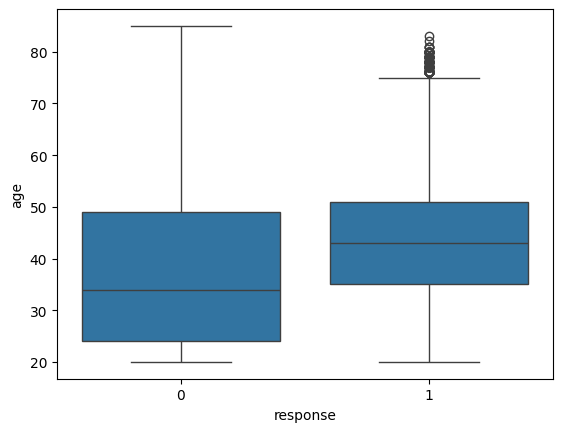

In [33]:
#Age
sns.boxplot(x= 'response', y='age', data=df4);

In [40]:
aux00 = df4.loc[df4['response'] == 0, 'age']
aux01 = df4.loc[df4['response'] == 1, 'age']


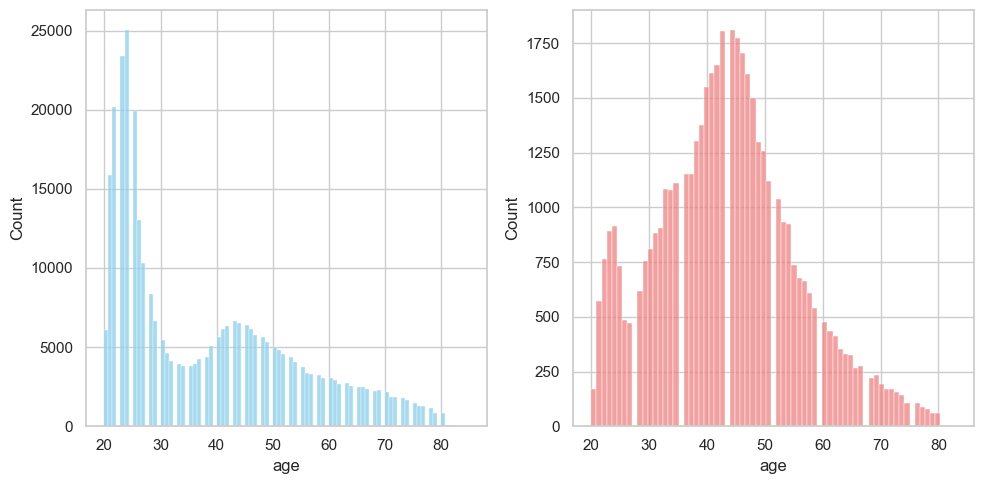

In [41]:
# seaborn style
sns.set_theme(style="whitegrid")

# Creating subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 linha, 2 colunas

# plot 01
sns.histplot(aux00, ax=axes[0], color='skyblue')

# Plot 01
sns.histplot(aux01, ax=axes[1], color='lightcoral')

plt.tight_layout()

plt.show()

<Axes: xlabel='response', ylabel='annual_premium'>

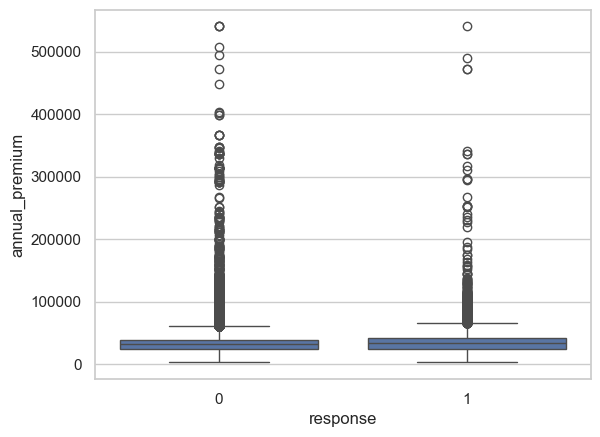

In [44]:
#'annual_premium'
sns.boxplot( x='response', y='annual_premium', data=df4 )

There is too many Outliers, let's see with some filtering, to have an better ideia

<Axes: xlabel='response', ylabel='annual_premium'>

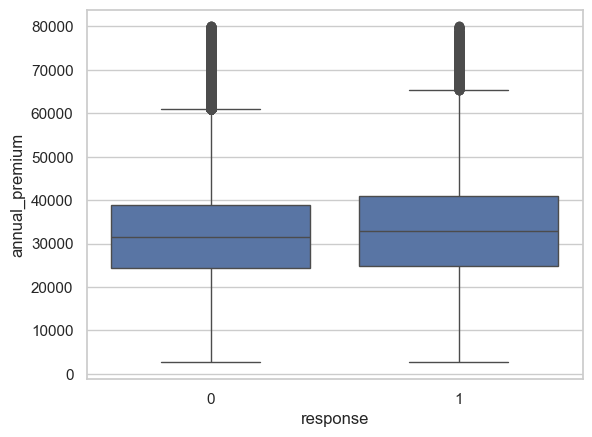

In [45]:
#'annual_premium'
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot( x='response', y='annual_premium', data=aux )

We can see that this variable alone doesn't matter to the results

In [50]:
#'driving_license'
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
aux.head()
#sns.barplot( x='response', y='driving_license', data=aux )

,response,driving_license,driving_license_perc
0,0,333628,0.877283
1,1,46669,0.122717


<Axes: xlabel='region_code', ylabel='id'>

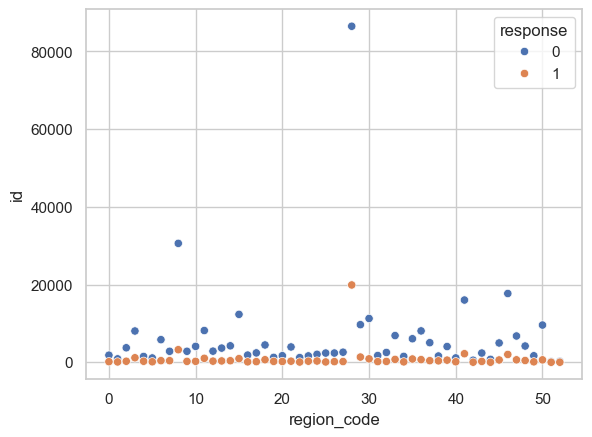

In [51]:
# 'region_code'
aux0 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()

sns.scatterplot( x='region_code', y='id', hue='response', data=aux0 )

In [52]:
#'previously_insured'
pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [53]:
#'vehicle_age'
df4[['vehicle_age', 'response']].value_counts( normalize=True ).reset_index()

,vehicle_age,response,proportion
0,between_1_2_year,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_year,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


<Axes: xlabel='response', ylabel='policy_sales_channel'>

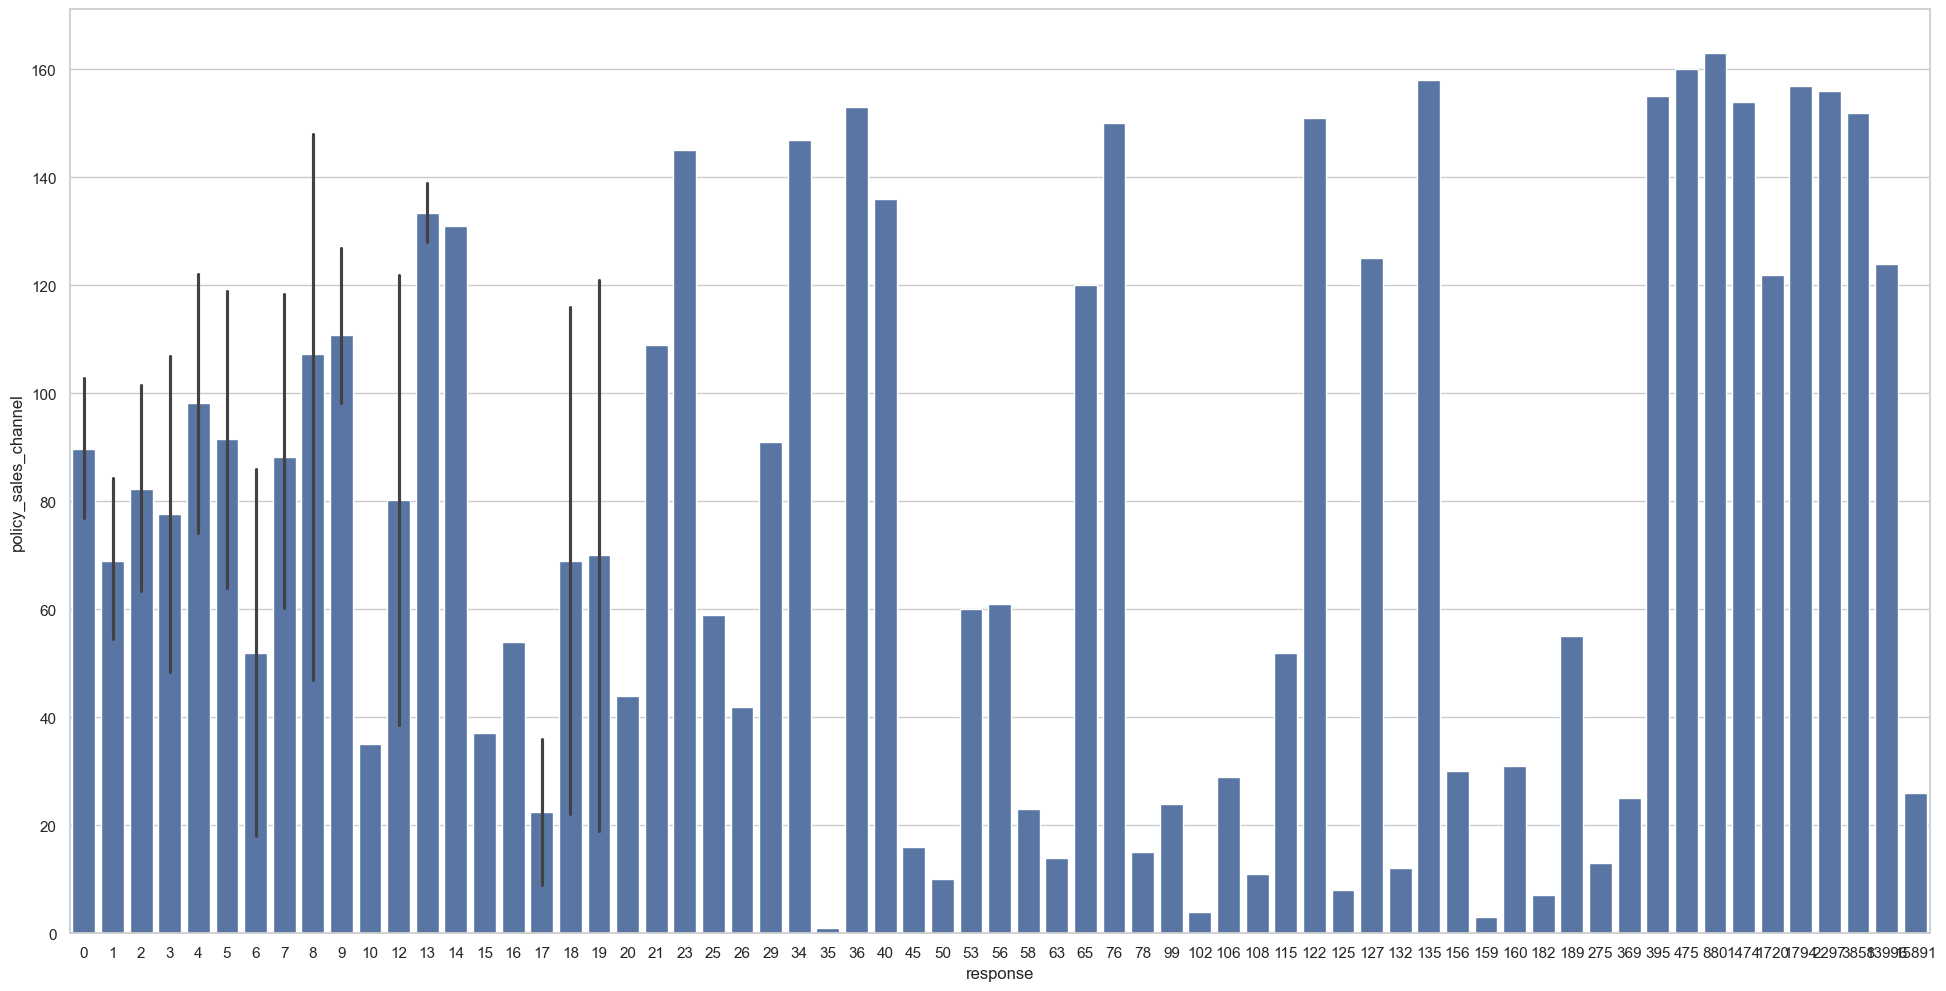

In [54]:
#'policy_sales_channel'
plt.figure( figsize=(24, 12 ))
aux = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel').sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux )

## 5.0 - Feature Selection

## 6.0 - Data Preparation

## 7.0 - Machine Learning

Com base no conjunto de dados fornecido sobre a previsão de venda cruzada de seguros de saúde, podemos formular algumas hipóteses interessantes para investigar:

1. Demografia e interesse em seguro de veículos:

Idade: Clientes mais jovens podem estar mais propensos a adquirir seguro de veículos, devido a maior probabilidade de comprarem seus primeiros carros ou por se interessarem por modelos mais novos que exigem seguro.
Gênero: Homens podem demonstrar maior interesse em seguro de veículos em comparação com mulheres, devido a uma possível associação cultural com automobilismo.
Estado civil: Solteiros podem ter maior probabilidade de adquirir seguro de veículos, já que casados podem compartilhar veículos e apólices com o cônjuge.
Localização: Clientes em áreas urbanas ou com maior densidade populacional podem ser mais propensos a adquirir seguro de veículos, devido à maior necessidade de locomoção e maior risco de acidentes.

2. Comportamento de compra e interesse em seguro de veículos:

Posse de veículo: Clientes que já possuem um seguro de saúde e também possuem um veículo têm maior probabilidade de adquirir um seguro para o veículo.
Tempo como cliente: Clientes mais antigos e com bom histórico de pagamento podem estar mais propensos a adquirir outro produto da seguradora, como o seguro de veículos.
Canal de vendas: Clientes que adquiriram o seguro de saúde por meio de um canal específico (online, telefone, agente) podem ter maior probabilidade de adquirir o seguro de veículos pelo mesmo canal.

3. Fatores socioeconômicos e interesse em seguro de veículos:

Renda anual: Clientes com renda anual mais alta podem estar mais propensos a adquirir seguro de veículos, pois têm maior poder aquisitivo para comprar e manter um veículo.
Nível educacional: Clientes com maior nível educacional podem ter uma percepção diferente sobre a importância do seguro e ser mais propensos a adquiri-lo.
Histórico de acidentes: Clientes com histórico de acidentes podem estar mais conscientes dos riscos e ser mais propensos a adquirir um seguro de veículos.

4. Características do seguro de saúde e interesse em seguro de veículos:

Tipo de plano de saúde: Clientes com planos de saúde mais completos podem estar mais propensos a adquirir seguro de veículos, demonstrando uma tendência a se prevenir contra riscos.
Valor do prêmio do seguro de saúde: Clientes que pagam um valor mais alto pelo seguro de saúde podem ter maior probabilidade de adquirir seguro de veículos, indicando maior disponibilidade financeira.
Observações:

Essas são apenas hipóteses iniciais, e a análise dos dados pode revelar outras relações e insights relevantes.
É importante realizar uma análise exploratória dos dados para verificar a validade dessas hipóteses e identificar possíveis vieses.
As conclusões da análise devem ser cuidadosamente consideradas, levando em conta o contexto do problema e as limitações dos dados.
Com essas hipóteses, você pode iniciar sua análise e explorar os dados para identificar os fatores que influenciam a probabilidade de um cliente adquirir um seguro de veículos.
